<a href="https://colab.research.google.com/github/mishal9/Python-notebooks/blob/master/BioBERT_Augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [2]:
!pip install pytorch-pretrained-bert
!pip install transformers
!pip install pytorch_transformers
!pip install seqeval

     |████████████████████████████████| 133kB 8.1MB/s 
     |████████████████████████████████| 133kB 10.1MB/s 
     |████████████████████████████████| 6.9MB 9.4MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
ERROR: botocore 1.19.25 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 1.3MB 8.6MB/s 
     |████████████████████████████████| 1.1MB 24.4MB/s 
     |████████████████████████████████| 890kB 19.1MB/s 
     |████████████████████████████████| 2.9MB 46.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=db79642ffc1dba666fabd71e2aab07f5a0e19ab50a897a381d88fc94c7045d6d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 8.4MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
  Creat

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
import re
import csv
import itertools

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [5]:
class SentenceFetch(object):
  
  def __init__(self, data):
    self.data = data
    self.sentences = []
    self.tags = []
    self.sent = []
    self.tag = []
    
    # make tsv file readable
    with open(self.data) as tsv_f:
      reader = csv.reader(tsv_f, delimiter='\t')
      for row in reader:
        if len(row) == 0:
          if len(self.sent) != len(self.tag):
            break
          self.sentences.append(self.sent)
          self.tags.append(self.tag)
          self.sent = []
          self.tag = []
        else:
          self.sent.append(row[0])
          self.tag.append(row[1])   
          
      self.sentences.append(self.sent)
      self.tags.append(self.tag)
  
  def getSentences(self):
    return self.sentences
  
  def getTags(self):
    return self.tags

In [6]:
corpora = '/content/gdrive/My Drive/BMI_598/bionlp_corpora'
sentences = []
tags = []
for subdir, dirs, files in os.walk(corpora):
    for file in files:
        if file == 'train.tsv':
            path = os.path.join(subdir, file)
            sent = SentenceFetch(path).getSentences()
            tag = SentenceFetch(path).getTags()
            sentences.extend(sent)
            tags.extend(tag)

In [7]:
len(sentences)

16318

In [8]:
print(sentences[-1])
print(tags[-1])

['aspiration', 'PNA', 'breaking', 'up', 'thick', 'Pulmonary', 'embolism', '/', 'DVTs', 'Candidal', 'vaginitis', 'Orthostatic', 'hypotension', 'carotid', 'stent', 'with', 'Plavix', 'systolic', 'blood', 'pressure', 'greater', 'than', '130', 'Crohn', "'s", 'disease', 'on', 'prednisone', ',', 'latent', 'TB', 'on', 'INH', 'and', 'hepatitis', 'B', 'on', 'lamivudine', 'with', 'recent', 'MRSA', 'bacteremia', '.']
['B-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'O', 'I-Reason', 'B-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'O', 'I-Drug', 'B-Reason', 'I-Reason', 'I-Reason', 'I-Reason', 'I-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'I-Reason', 'O', 'I-Drug', 'O', 'B-Reason', 'I-Reason', 'O', 'I-Drug', 'O', 'B-Reason', 'I-Reason', 'O', 'I-Drug', 'O', 'O', 'B-Reason', 'I-Reason', 'O']


In [9]:
'''
replicate_sentence = sentences[-2:]
replicate_tag = tags[-2:]

print(replicate_sentence)
print(replicate_tag)

boost = 10000

for i in range(0, boost):
  sentences.extend(replicate_sentence)
  tags.extend(replicate_tag)
'''

'\nreplicate_sentence = sentences[-2:]\nreplicate_tag = tags[-2:]\n\nprint(replicate_sentence)\nprint(replicate_tag)\n\nboost = 10000\n\nfor i in range(0, boost):\n  sentences.extend(replicate_sentence)\n  tags.extend(replicate_tag)\n'

In [10]:
print(sentences[-1])
print(tags[-1])

['aspiration', 'PNA', 'breaking', 'up', 'thick', 'Pulmonary', 'embolism', '/', 'DVTs', 'Candidal', 'vaginitis', 'Orthostatic', 'hypotension', 'carotid', 'stent', 'with', 'Plavix', 'systolic', 'blood', 'pressure', 'greater', 'than', '130', 'Crohn', "'s", 'disease', 'on', 'prednisone', ',', 'latent', 'TB', 'on', 'INH', 'and', 'hepatitis', 'B', 'on', 'lamivudine', 'with', 'recent', 'MRSA', 'bacteremia', '.']
['B-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'O', 'I-Reason', 'B-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'O', 'I-Drug', 'B-Reason', 'I-Reason', 'I-Reason', 'I-Reason', 'I-Reason', 'I-Reason', 'B-Reason', 'I-Reason', 'I-Reason', 'O', 'I-Drug', 'O', 'B-Reason', 'I-Reason', 'O', 'I-Drug', 'O', 'B-Reason', 'I-Reason', 'O', 'I-Drug', 'O', 'O', 'B-Reason', 'I-Reason', 'O']


In [11]:
print(len(sentences))
print(len(tags))

replication_sentencess = []
replication_tags = []
boost = 10
for sent, labs in zip(sentences, tags):
  for word, label in zip(sent, labs):
    if "Ade" in label or "Reason" in label:
      for i in range(1, boost):
        replication_sentencess.append(sent)
        replication_tags.append(labs)

print("After augmentation") 

sentences.extend(replication_sentencess)
tags.extend(replication_tags)

#sentences = replication_sentencess
#tags = replication_tags

print(len(sentences))
print(len(tags))

print(sentences[:100])
print(tags[:100])

16318
16318
After augmentation
45154
45154
[['Admission', 'Date', ':', '[', '**', '2140-5-17', '**', ']', 'Discharge', 'Date', ':', '[', '**', '2140-5-28', '**', ']', 'Service', ':', 'NEUROLOGY', 'Allergies', ':', 'Codeine', '/', 'Quinidine', '/', 'Quinine', '/', 'Norvasc', '/', 'Pravachol', 'Attending', ':[', '**', 'Last', 'Name', '(', 'NamePattern1', ')', '1838', '**', ']', 'Chief', 'Complaint', ':', 'Lightheadedness', ',', 'dizziness', ',', 'palpitations', '.'], ['Major', 'Surgical', 'or', 'Invasive', 'Procedure', ':', 'Cardioversion', 'History', 'of', 'Present', 'Illness', ':', 'Briefly', ',', 'Mrs.', '[', '**', 'Known', 'lastname', '107414', '**', ']', 'is', 'a', 'very', 'pleasant', '[', '**', 'Age', 'over', '90', '**', ']', 'yo', 'woman', 'with', 'CAD', ',', 'paroxysmal', 'atrial', 'fibrillation', 's', '/', 'p', 'failed', 'cardioversion', '(', 'most', 'recent', 'on', '[', '**', '2140-5-5', '**', ']', ')', ',', 'CKD', '(', 'Stage', 'III', ')', 'who', 'initially', 'presented', '[',

In [12]:
len(sentences), len(tags)

(45154, 45154)

In [13]:
tag_values = list(set(itertools.chain.from_iterable(tags)))
tag_values.append("PAD")

tag2idx = {t: i for i,t in enumerate(tag_values)}

for i, t in enumerate(tag_values):
    print(t, i)

I-Drug 0
B-Reason 1
I-Reason 2
B-Drug 3
B-Ade 4
I-Ade 5
O 6
PAD 7


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

MAX_LEN = 75
BATCH_SIZE = 32
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1', do_lower_case=False)


In [15]:
def tok_with_labels(sent, text_labels):
  '''tokenize and keep labels intact'''
  tok_sent = []
  labels = []
  for word, label in zip(sent, text_labels):
    tok_word = tokenizer.tokenize(word)
    n_subwords = len(tok_word)

    tok_sent.extend(tok_word)
    labels.extend([label] * n_subwords)
  return tok_sent, labels

tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]

In [16]:
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]

In [17]:
# padding ids and labels

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [18]:
print(input_ids)

[[24930 11234 14265 ... 53951  1475   114]
 [ 2868 56631  1137 ...  2793  1113   164]
 [  119     0     0 ...     0     0     0]
 ...
 [32401  5132  2116 ... 25247 10399  1114]
 [32401  5132  2116 ... 25247 10399  1114]
 [32401  5132  2116 ... 25247 10399  1114]]


In [19]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [20]:
print(attention_masks)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [22]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [23]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


model = BertForTokenClassification.from_pretrained(
    "dmis-lab/biobert-large-cased-v1.1",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

model.to(device)

Some weights of the model checkpoint at dmis-lab/biobert-large-cased-v1.1 were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not init

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(58996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [24]:
'''
from transformers import AutoTokenizer, AutoModelForMaskedLM  
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")  
model = AutoModelForMaskedLM.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

model.to(device)
'''

'\nfrom transformers import AutoTokenizer, AutoModelForMaskedLM  \ntokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")  \nmodel = AutoModelForMaskedLM.from_pretrained("dmis-lab/biobert-base-cased-v1.1")\n# tell Pytorch to use the GPU if available\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nprint(\'There are %d GPU(s) available.\' % torch.cuda.device_count())\nprint(\'We will use the GPU:\', torch.cuda.get_device_name(0))\n\nmodel.to(device)\n'

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)
epochs = 3
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [26]:
from seqeval.metrics import f1_score, accuracy_score

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.15658804716544197


Epoch:  33%|███▎      | 1/3 [33:42<1:07:24, 2022.05s/it]

Validation loss: 0.030168461829381273
Validation Accuracy: 0.9890664662421828

Average train loss: 0.029359456370460918


Epoch:  67%|██████▋   | 2/3 [1:07:27<33:43, 2023.12s/it]

Validation loss: 0.020489777027712118
Validation Accuracy: 0.9918884807918658

Average train loss: 0.02263990365090864


Epoch: 100%|██████████| 3/3 [1:41:10<00:00, 2023.42s/it]

Validation loss: 0.020564272442409763
Validation Accuracy: 0.9920870144787781



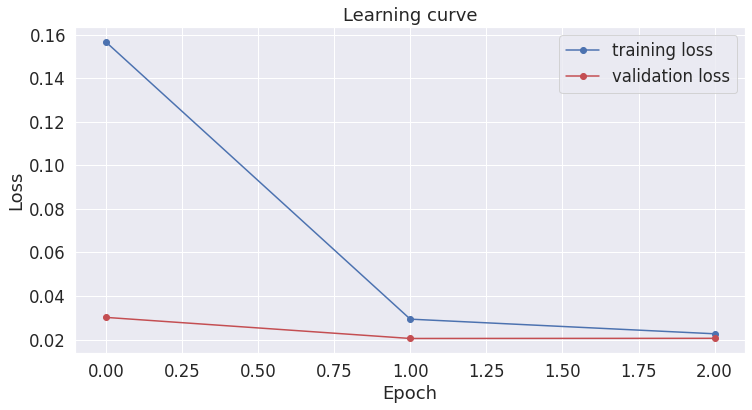

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [28]:
corpora = '/content/gdrive/My Drive/BMI_598/bionlp_corpora'
test_sentences = []
test_tags = []
for subdir, dirs, files in os.walk(corpora):
    for file in files:
        if file == 'test.tsv':
            path = os.path.join(subdir, file)
            test_sent = SentenceFetch(path).getSentences()
            test_sentences.extend(test_sent)
            test_tag = SentenceFetch(path).getTags()
            test_tags.extend(test_tag)

In [29]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [30]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sentences, test_tags)
]

In [31]:
tokenized_texts = [token_label_pair[0][:512] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1][:512] for token_label_pair in tokenized_texts_and_labels]

print(tokenized_texts[:10])
print(labels[:10])

[['Ad', '##mission', 'Date', ':', '[', '*', '*', '219', '##2', '-', '2', '-', '17', '*', '*', ']', 'Disc', '##har', '##ge', 'Date', ':', '[', '*', '*', '219', '##2', '-', '3', '-', '6', '*', '*', ']', 'Date', 'of', 'Birth', ':', '[', '*', '*', '212', '##2', '-', '6', '-', '18', '*', '*', ']', 'Sex', ':', 'M', 'Service', ':', 'ME', '##DI', '##CIN', '##E', 'ICU', 'HI', '##ST', '##OR', '##Y', 'OF', 'PR', '##ES', '##EN', '##T', 'ILL', '##NES', '##S', ':', 'The', 'patient', 'is', 'a', '69', 'year', '-', 'old', 'gentleman', 'with', 'an', 'extensive', 'tobacco', 'history', 'complaining', 'of', 'fever', 'to', '102', ',', 'productive', 'cough', 'and', 'progressive', 'short', '##ness', 'of', 'breath', 'for', 'two', 'to', 'three', 'days', '.'], ['The', 'patient', 'also', 'commented', 'on', 'associated', 'mal', '##ais', '##e', 'and', 'dia', '##rr', '##hea', 'for', 'two', 'episodes', '.'], ['The', 'patient', 'denied', 'sick', 'contacts', ',', 'chest', 'pain', ',', 'did', 'report', 'receiving', 'the

In [32]:
test_tokens, test_labels = [], []

for tokenized_text, label in zip(tokenized_texts, labels):
  for token, tag in zip(tokenized_text, label):
    if token.startswith("##"):
      test_tokens[-1] = test_tokens[-1] + token[2:]
    else:   
      test_labels.append(tag)
      test_tokens.append(token)

In [33]:
print(len(test_tokens))
print(len(test_labels))

462985
462985


In [34]:
test_sentences =  [[' '.join(i)] for i in test_sentences]

In [35]:
print(len(test_sentences))

22433


In [36]:
print(test_sentences[0:10])

[['Admission Date : [ ** 2192-2-17 ** ] Discharge Date : [ ** 2192-3-6 ** ] Date of Birth : [ ** 2122-6-18 ** ] Sex : M Service : MEDICINE ICU HISTORY OF PRESENT ILLNESS : The patient is a 69 year - old gentleman with an extensive tobacco history complaining of fever to 102 , productive cough and progressive shortness of breath for two to three days .'], ['The patient also commented on associated malaise and diarrhea for two episodes .'], ['The patient denied sick contacts , chest pain , did report receiving the flu vaccine this year and has no history of prior hospitalizations for chronic obstructive pulmonary disease flares , pneumonias or any other pulmonary complications .'], ['The patient denies recent travel , lower extremity trauma , calf pain or any other risk factors for pulmonary embolus .'], ['Review of systems was otherwise negative .'], ['PAST MEDICAL HISTORY : 1 .'], ['Hypertension .'], ['2 .'], ['Fast heart rate .'], ['3 .']]


In [37]:
pred_tokens, pred_labels = [], []

for sentence in test_sentences:
  sentence = ' '.join([str(elem) for elem in sentence]) 
  tokenized_sentence = tokenizer.encode(sentence,max_length=512)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  print(input_ids.shape)
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  print(tokens)
  for token, label_idx in zip(tokens, label_indices[0]):
    if token != '[CLS]' and token != '[SEP]':
      if token.startswith("##"):
        pred_tokens[-1] = pred_tokens[-1] + token[2:]
      else:
        pred_labels.append(tag_values[label_idx])
        pred_tokens.append(token)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Streaming output truncated to the last 5000 lines.
torch.Size([1, 5])
['[CLS]', 'Left', 'negative', '.', '[SEP]']
torch.Size([1, 13])
['[CLS]', 'No', 'withdrawal', 'at', 'R', 'arm', ',', 'leg', ',', 'L', 'leg', '.', '[SEP]']
torch.Size([1, 9])
['[CLS]', 'With', '##draw', '##al', 'at', 'R', 'arm', '.', '[SEP]']
torch.Size([1, 12])
['[CLS]', 'Response', 'to', 'the', 'no', '##xious', 'stimuli', 'at', 'left', 'arm', '.', '[SEP]']
torch.Size([1, 12])
['[CLS]', 'None', 'at', 'right', 'arm', ',', 'leg', 'and', 'left', 'leg', '.', '[SEP]']
torch.Size([1, 38])
['[CLS]', 'Re', '##flex', '##es', ':', 'B', 'T', 'Br', 'Pa', 'An', '##kle', 'Right', '2', '2', '2', '3', '3', 'Left', '2', '2', '2', '2', '2', 'To', '##es', 'were', 'up', '##going', 'at', 'the', 'right', ',', 'down', 'at', 'the', 'left', '.', '[SEP]']
torch.Size([1, 14])
['[CLS]', 'Co', '##ordination', ':', 'Unable', 'to', 'examine', 'due', 'to', 'ina', '##tten', '##tion', '.', '[SEP]']
torch.Size([1, 15])
['[CLS]', 'Men', '##inge', '##al

In [38]:
print("TOKEN\t\tTEST\t\tPREDICTION")
print("===========================")
pred_tokens_new = []
test_tokens_new = []
pred_labels_new = []
test_labels_new = []
for token, t, pred_label, test_label in zip(pred_tokens, test_tokens, pred_labels, test_labels):
  if token == t:
    print("{}\t\t\t\t{}\t\t\t\t{}\t\t{}".format(token, t, test_label, pred_label))
    pred_tokens_new.append(token)
    test_tokens_new.append(t)
    pred_labels_new.append(pred_label)
    test_labels_new.append(test_label)

Streaming output truncated to the last 5000 lines.
*				*				O		O
*				*				O		O
*				*				O		O
-				-				O		O
.				.				O		O
:				:				O		O
.				.				O		O
:				:				O		O
:				:				O		O
,				,				O		O
,				,				O		O
-				-				O		O
-				-				O		O
*				*				O		O
-				-				O		O
-				-				O		O
*				*				O		O
*				*				O		O
-				-				O		O
*				*				O		O
-				-				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
-				-				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
[				[				O		O
*				*				O		O
*				*				O		O
-				-				O		O
*				*				O		O
*				*				O		O
]				]				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
*				*				O		O
:				:				O		O
.				.				O		O
*				*				O		O
*				*				O		O
the				the				O		O
-				-				O		O
and				and				O		O
the				the				O		O
the				the				O		O
.		

In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(test_labels_new, pred_labels_new, digits=5))

              precision    recall  f1-score   support

       B-Ade    1.00000   1.00000   1.00000         1
      B-Drug    0.58333   0.70000   0.63636        10
    B-Reason    0.50000   0.25000   0.33333        12
       I-Ade    0.80000   0.66667   0.72727         6
      I-Drug    0.76852   0.79808   0.78302       104
    I-Reason    0.47059   0.48485   0.47761        33
           O    0.99748   0.99748   0.99748     18232

    accuracy                        0.99467     18398
   macro avg    0.73142   0.69958   0.70787     18398
weighted avg    0.99462   0.99467   0.99461     18398



In [41]:
output = pd.DataFrame(list(zip(pred_tokens_new, test_tokens_new, pred_labels_new, test_labels_new)), 
               columns =["pred_tokens", "test_tokens", "pred_labels", "test_labels"]) 

In [42]:
output.head(5)

,pred_tokens,test_tokens,pred_labels,test_labels
0,Admission,Admission,O,O
1,Date,Date,O,O
2,:,:,O,O
3,[,[,O,O
4,*,*,O,O


In [43]:
counter = 1
for index, row in output.iterrows():    
    output.at[index,'Sentence #'] = counter
    if row['test_tokens'] == '.':
        counter = counter +1

In [44]:
output.head(5)

,pred_tokens,test_tokens,pred_labels,test_labels,Sentence #
0,Admission,Admission,O,O,1.0
1,Date,Date,O,O,1.0
2,:,:,O,O,1.0
3,[,[,O,O,1.0
4,*,*,O,O,1.0


In [45]:
class LabelGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda data : [(w, t) for w, t in zip(data["pred_labels"].values.tolist(),
                                                           data["test_labels"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [data for data in self.grouped]

    def get_next(self):
        try:
            data = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return data
        except:
            return None

In [46]:
getter = LabelGetter(output)
pred_labels = [[str(word[0]) for word in sentence] for sentence in getter.sentences]
test_labels = [[str(word[1]) for word in sentence] for sentence in getter.sentences]

In [47]:
from seqeval.scheme import IOB2
from seqeval.metrics import f1_score, accuracy_score, classification_report

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         Ade       0.75      0.60      0.67         5
        Drug       0.83      0.80      0.82       100
      Reason       0.31      0.32      0.32        28

   micro avg       0.71      0.69      0.70       133
   macro avg       0.63      0.57      0.60       133
weighted avg       0.72      0.69      0.71       133

